In [1]:
import numpy as np
from numpy.random import choice

import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import glob
import os

import numpy as np
from numpy.random import choice
import random
from scipy.integrate import odeint


In [2]:
##standing wave solution of Fisher wave
def standing_wave(y0,x,D,rw):
    w = y0[0]      ##initial value for wave profile at x =0, i.e. w(x=0)
    z = y0[1]      ##initial value for rate of change of profile w.r.t. position x , at x=0 i.e. dw/dx(x=0)
    dwdx = z
    dzdx =(-2*((rw*D)**.5)*dwdx -w*rw*(1-w))/D
    
    return [dwdx,dzdx]

In [72]:
def fit_dist(r,alpha,dist_key):
    dist_dict = {'exponential':np.random.exponential,
                 'gamma':np.random.gamma,
                 'normal':np.random.normal}
    func = dist_dict[dist_key]
    s_bar  = r*func(alpha)
    return s_bar

##standing wave solution of Fisher wave
def standing_wave(y0,x,D,rw):
    w = y0[0]      ##initial value for wave profile at x =0, i.e. w(x=0)
    z = y0[1]      ##initial value for rate of change of profile w.r.t. position x , at x=0 i.e. dw/dx(x=0)
    dwdx = z
    dzdx =(-2*((rw*D)**.5)*dwdx -w*rw*(1-w))/D
    
    return [dwdx,dzdx]


###given a list of demes (indexes), pick two neighobiring ones at random
def rand_neighbors(demes):
    ind_1 = np.random.choice(demes)
    left = demes[:ind_1][-1:]
    right = demes[ind_1:][1:2]
    neighb = np.append(left,right).flatten()
    ind_2=choice(neighb)
    neigh = [ind_1,ind_2]
    neigh.sort()
    return np.array(neigh)

## covert a list of cell counts for each particle type to an array of 
#all particles represented with their type represented by an itenged
def counts_to_cells(counts,n_allele):
    cells = np.unique(cells,return_counts=True)
    return cells

## covert an array of all cells and their type to a list of counts for each cell type 
def cells_to_counts(cell_types,g_rates):
    g_r = np.unique(cell_types,return_counts=True)[0]
    raw_counts = np.unique(cell_types,return_counts=True)[1]
    cell_counts = []
    for i in g_rates:
        if any(g_r == i):
            cell_counts.append(raw_counts[np.where(g_r == i)[0][0]])
        else:
            cell_counts.append(0)
    cell_counts = np.array(cell_counts)

    return cell_counts
    
    
## from a list 2d array of the cell list from two neighboring demes
##pick two cells to be swapped at random and return resulting cell list
def migration(cell_counts,g_rates,K,r):
    picks = []
    cell_types = [] 
    for i in [0,1]:
        pick_ind=choice(np.arange(K))
        picks.append(np.arange(K) == pick_ind)
        cell_types.append(np.repeat( g_rates, cell_counts[i].astype(int)))
    picks = np.array(picks)
    keep =  ~np.array(picks)
    


    cell_types[0]= np.append(cell_types[0][keep[0]], [cell_types[1][picks[1]]])
    cell_types[1]= np.append(cell_types[1][keep[1]], [cell_types[0][picks[0]]])
    return np.array(cell_types)

## from the cell list from the chosen d0eme
##pick *-\\\\\\\\\\\\\\\
#wo cells and replace one with a duplicate of the other according
##to transition matrix
def duplication(cell_counts,g_rates,K,r):
    pick_ind=choice(np.arange(K),2,replace= False)
    cell_types = np.repeat(g_rates, cell_counts.astype(int))
    picks = np.array([np.arange(K) == pick_ind[i] for i in [0,1]])
    r= np.random.random()
    P=prob_mat(g_rates)
    #print(cell_types)
    if P[tuple([np.where(cell_types[ind] == g_rates)[0] for ind in pick_ind])]> r:
        cell_types[pick_ind[1]] =cell_types[pick_ind[0]]
    return cell_types
    
 ## from the cell list from the chosen deme
##pick a cell and mutate it with probability according to mutation rate
def mutation(mu,alpha,dist_key, cell_counts,g_rates,K,r):

    cell_types = np.repeat(g_rates,cell_counts.astype(int))
    pick_ind=choice(np.arange(K))
    p= np.random.random()
    if mu>p:
        if cell_types[pick_ind] == r:
            print('hi')
            cell_types[pick_ind] = fit_dist(r,alpha,dist_key)
            g_rates = np.sort(np.append(g_rates,[cell_types[pick_ind]]))
    return cell_types, g_rates

## perform stepping stone alogrithm (migration, duplication, mutation) for each step
## and return new simulation box, recenter

def recenter(L, g_rates, K):
    shift = 0
    L_empty= np.append([K],np.zeros(len(g_rates)-1,dtype=float))
    while L[0,0]<int(.02*K):
        L=L[1:,:]
        shift+=1
    for i in range(shift):
        L=np.append(L,[L_empty],axis=0)
    return L


def update(L,g_rates,dist_key,K,r,alpha,mu):
    demes = np.arange(len(L))
    #migration
    neighbors = rand_neighbors(demes)
    cells = migration(L[neighbors],g_rates,K,r)
    counts = [cells_to_counts(cell,g_rates) for cell in cells]
    L[neighbors] = np.array(counts)

    #duplication
    dup_deme = choice(demes)
    cells = duplication(L[dup_deme],g_rates,K,r)
    counts = cells_to_counts(cells,g_rates)
    L[dup_deme] = counts

    ##mutation
    mut_deme = choice(demes)
    cells, g_rates = mutation(mu,alpha,dist_key, L[mut_deme],g_rates,K,r)
    counts = cells_to_counts(cells,g_rates)
    L[mut_deme] = counts
    
    

    return L,g_rates
def initialize(K,r,alpha,mu):
    stand = odeint(standing_wave,[1,-(2*2**.5)/K],np.arange(70),args=(2*2**.5,1))[:,0]
    w_0 = (K*stand).astype(int)
    w_0 = w_0[w_0>1]
    L = np.vstack(((K-w_0),w_0)).T
    g_rates = np.array([0,r])

    ##initialize array
    L_empty= np.append([K],np.zeros(len(g_rates)-1))

    for i in range(50):
        L= np.append(L,[L_empty],axis=0)
    return L.astype(int), g_rates

def prob_mat(g_rates):
    P = np.ones((len(g_rates),len(g_rates)))
    P[0,:] = 1-g_rates
    return P 

## run one dimensional stepping stone for a given number of possible beneficil mutations, and generations   
def run_stepping_stone(n_gen,K,r,alpha,mu,dist_key = 'exponential'):
    func_args = [K,r,alpha,mu]
    ##initialize probability matrix
    c = 1
    move=10
    L, g_rates = initialize(*func_args)
    L_history=[L]
    #begin evolution
    count = 0
    for t in range(n_gen):
        for dt in range(K):
            L,g_rates = update(L,g_rates,dist_key,*func_args)
            L= recenter(L,g_rates,K)
        L_history.append(L)

        count+=1
    return L_history, g_rates


## run a two allele 1d stepping stone simulation, recording mutant establishment and fixation along simulation box
def fix_time(K,n_allele,r,alpha,mu,thresh, track):
    func_args = [K,n_allele,r,alpha,mu]
    ##initialize probability matrix
    P = np.ones((n_allele+1,n_allele+1))
    P[0,1:] = 1-r*(alpha**np.arange(n_allele))
    
    L,L_empty = initialize(*func_args)
    L_history=[L]
    #begin evolution
    fixed=False
    t = 0
    if track:
        fix_times = np.zeros(len(L))
        est_times = np.zeros(len(L))
        fb_1, eb_1 = (np.zeros(len(L)) == 1),(np.zeros(len(L)) == 1) 
    while not fixed:
        L = update(L,L_empty,P,*func_args)
        L = recenter(L,L_empty,K)
        fix_bools = L[:,1] < int(thresh*K)
        est_bools = L[:,2] > int(1/(r*alpha))
        fixed= all(fix_bools)
        if track:
            fix_times  = [max(i,time) for i, time in zip((fix_bools^fb_1)*t,fix_times)]
            est_times  = [max(i,time) for i, time in zip((est_bools^eb_1)*t,est_times)]
            fb_1,eb_1 = fix_bools,est_bools
        t+=1
    if not track:
        return L
    else: 

        fix_times,est_times

      

        

In [ ]:
    func_args = [K,r,alpha,mu]
    ##initialize probability matrix
    c = 1
    move=10
    L, g_rates = initialize(*func_args)
    L_history=[L]
    #begin evolution
    count = 0
    for t in range(n_gen):
        for dt in range(K):
            L,g_rates = update(L,g_rates,dist_key,*func_args)
            L = recenter(L,g_rates,K)
        L_history.append(L)

        count+=1
    return L_history

In [73]:
K= 100
n_allele=2

r=.1
alpha=5
mu=.1

thresh=3/K
L,g=run_stepping_stone(1000,K,r,alpha,mu,dist_key = 'exponential')

hi


ValueError: could not broadcast input array from shape (3) into shape (2)

In [40]:
fit_dist(.5,'exponential',.1)

TypeError: fit_dist() takes 2 positional arguments but 3 were given

In [71]:
np.random.random()

0.005172276822604904

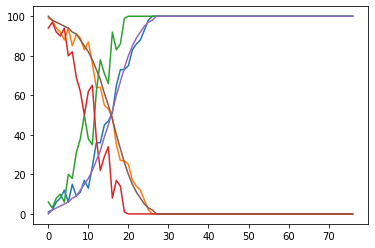

In [39]:
plt.plot(L[1])
plt.plot(L[-1])
plt.plot(L[0])

In [544]:
neighbors = rand_neighbors(demes)
cells = migration(L[neighbors],g_rates,K,r)
counts = [cells_to_counts(cell,g_rates) for cell in cells]
L[neighbors] = np.array(counts)

In [607]:
neighbors = choice(demes)

In [650]:
P=prob_mat(g_rates)
#print(cell_types)
P[tuple([np.where(cell_types[ind] == g_rates)[0] for ind in pick_ind])]

array([1.])

In [643]:
tuple([np.where(cell_types[ind] == g_rates)[0] for ind in pick_ind])

(array([1]), array([1]))

In [662]:
cell_types = np.repeat(g_rates, cell_counts.astype(int))
cell_types[[0,-1]]

array([0. , 0.1])

In [663]:
P[tuple([np.where(cell_types[ind] == g_rates)[0] for ind in pick_ind])]

array([0.9])

In [608]:
cell_counts = L[neighbors]


In [665]:
P

array([[1. , 0.9],
       [1. , 1. ]])

In [667]:
P[0,1]

0.9

In [659]:
P[tuple([np.where(cell_types[ind] == g_rates)[0] for ind in pick_ind])]

array([1.])

In [664]:
pick_ind = np.array([0,-1])
cell_types = np.repeat(g_rates, cell_counts.astype(int))
r= np.random.random()
P=prob_mat(g_rates)
#print(cell_types)
if P[tuple([np.where(cell_types[ind] == g_rates)[0] for ind in pick_ind])]> r:
    cell_types[pick_ind[1]] =cell_types[pick_ind[0]]

In [657]:
cells= cell_types

In [600]:
[cells_to_counts(cell,g_rates) for cell in cells]

[array([75, 25]), array([99,  1])]

In [601]:
L[[19,20]]

array([[ 74,  26],
       [100,   0]])

In [658]:
cells_to_counts(cell_types,g_rates)

array([10, 90])

In [623]:
L[neighbors]

array([ 9, 91])

In [439]:
from stepping_stone_funcs import*
from tqdm import tqdm
from itertools import product
import numpy as np
import datetime

start = datetime.datetime.now()
K_space = np.array([100,500])
mu_space = np.array([.0005,.001,.005])
alphas = np.array([3,5])

reps= 1

params_out = ['reps='  +str(reps),'K='+str(K_space),'mu='+str(mu_space),'alphas='+str(alphas) ]

r=.1

results = []

for rep, K,mu,a in tqdm(product(range(reps), K_space,mu_space, alphas)):
    L = fix_time(K,2,r,a,mu,3/K)
    results.append(np.asarray(L))
    
    
    
    np.save('two_allele_data_%s.npy' % start,np.array([results,params_out]))
    
np.save('two_allele_data_%s.npy' % start,np.array([results,params_out]))

    
    
    
            





    
    
  
    
    
    
    
            




1it [02:40, 160.24s/it]

OSError: [Errno 22] Invalid argument

In [444]:
np.save('two_allele_data.npy',np.array([results,params_out]))

OSError: [Errno 22] Invalid argument

In [443]:
np.array([results,params_out])

array([list([array([[[  0, 100,   0],
        [  3,  97,   0],
        [  4,  96,   0],
        ...,
        [100,   0,   0],
        [100,   0,   0],
        [100,   0,   0]],

       [[  1,  99,   0],
        [  2,  98,   0],
        [  2,  98,   0],
        ...,
        [100,   0,   0],
        [100,   0,   0],
        [100,   0,   0]],

       [[  1,  99,   0],
        [  2,  98,   0],
        [  2,  98,   0],
        ...,
        [100,   0,   0],
        [100,   0,   0],
        [100,   0,   0]],

       ...,

       [[  1,   9,  90],
        [  4,   2,  94],
        [  8,   1,  91],
        ...,
        [100,   0,   0],
        [100,   0,   0],
        [100,   0,   0]],

       [[  1,   9,  90],
        [  4,   2,  94],
        [  8,   1,  91],
        ...,
        [100,   0,   0],
        [100,   0,   0],
        [100,   0,   0]],

       [[  4,   2,  94],
        [  8,   1,  91],
        [ 11,   1,  88],
        ...,
        [100,   0,   0],
        [100,   0,   0],
        [10

In [417]:
fix_times = []
for i in range(len(L_hist[0])):
    fix_times.append(np.where(L_hist[:,i,1] <thresh)[0][0])

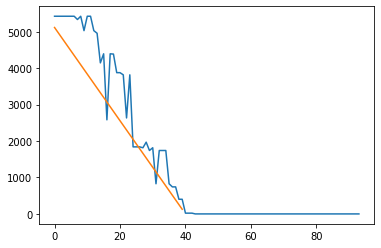

In [435]:
plt.plot(np.array(fix_times)/K)
plt.plot(100*(40-np.arange(40)) / (2*(r*alpha)**.5 - 2*(r)**.5))

In [429]:
np.arange(40)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [54]:
lengths = [len(u) for u in L_history]
hist_pad =  
for u in L_history:
    add= [] 
    for i in range((max(lengths) - len(u))):
        add.append(np.append([K],np.zeros(n_allele)))
    hist_pad.append(np.append(u,np.asarray(add),axis=0))

KeyboardInterrupt: 

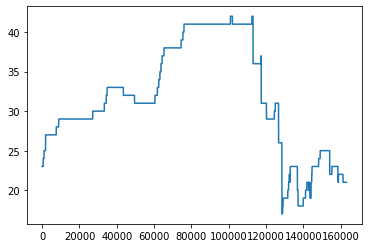

In [51]:
plt.plot([len(u) for u in L_history])

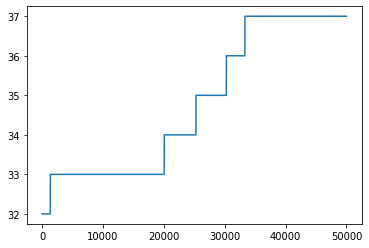

In [39]:
plt.plot([len(u) for u in out1])

In [545]:
out2 = run_stepping_stone(n_gen = 3000,K = 100,n_allele = 1,r = .1,alpha = 5,mu = .001)

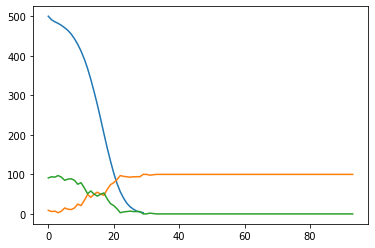

In [546]:
stand = odeint(standing_wave,[1,-(2*2**.5)/100],np.arange(70),args=(2*2**.5,1))[:,0]
w_0 = (500*stand).astype(int)
w_0 = w_0[w_0>1]
plt.plot(w_0)
plt.plot(out2[-1])

In [541]:
(2* 1.414)/500

0.005656

In [150]:
K=500
n_allele=1

L_empty= np.append([K],np.zeros(n_allele,dtype=int))


In [155]:
np.append(out[300],[L_empty],axis=0)
          

array([[126, 374],
       [191, 309],
       [228, 272],
       [276, 224],
       [290, 210],
       [315, 185],
       [337, 163],
       [360, 140],
       [375, 125],
       [388, 112],
       [402,  98],
       [420,  80],
       [438,  62],
       [444,  56],
       [447,  53],
       [464,  36],
       [467,  33],
       [474,  26],
       [481,  19],
       [483,  17],
       [487,  13],
       [489,  11],
       [493,   7],
       [495,   5],
       [497,   3],
       [495,   5],
       [497,   3],
       [498,   2],
       [499,   1],
       [500,   0]])

In [485]:
stand = odeint(standing_wave,[1,-.1*r**2],np.arange(50),args=(1,r))[:,0]

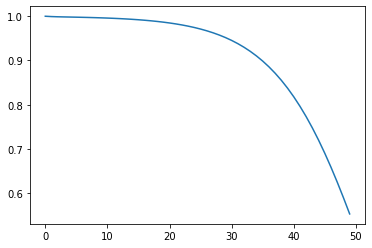

In [486]:
plt.plot(stand)

In [482]:
n_gen=1000
K=100
n_allele=3
r=.1
alpha=2
mu=.001
L_h = run_stepping_stone(n_gen,K,n_allele,r,alpha,mu)

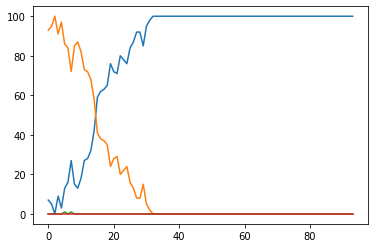

In [483]:
plt.plot(L_h[-1])

In [15]:
def fix_time_2allele(K,r,alpha,mu,thresh):
    func_args = [K,n_allele,r,alpha,mu]
    ##initialize probability matrix
    P = np.ones((n_allele+1,n_allele+1))
    P[0,1:] = 1-r*(alpha**np.arange(n_allele))
    
    stand = odeint(standing_wave,[1,-r**.5],np.arange(70),args=(1,r))[:,0]
    w_0 = (K*stand).astype(int)
    w_0 = w_0[w_0>1]
    
    ##initialize array
    L_empty= np.append([K],np.zeros(n_allele,dtype=int))
    L0 = np.zeros((len(w_0),n_allele+1),dtype=int)
    L0[:,1] = w_0
    L0[:,0] = K-w_0
    L= np.append(L0,[L_empty],axis=0)
 

    #begin evolution
    fixed=False
    fixed_hist=[]
    est_hist=[]
    t = 0
    while not fixed:
        L = update(L,L_empty,P,*func_args)
        fix_bools = L[:,1]< int(thresh*K)
        est_bools = L[:,2]> int(1/(r*alpha))
        fixed= all(fix_bools)
        if any(fix_bools):
            fixed_hist.append(fix_bools)
            
        if any(est_bools):
            est_hist.append(est_bools)
        t+=1

    return fixed_hist,est_hist,L

In [35]:
import datetime
from stepping_stone_funcs import*
start = datetime.datetime.now()
K_space = np.array([500,1000])
mu_space = np.array([.001,.005])
alphas = np.array([2,5])

params_out = ['K='+str(K_space),'mu='+str(mu_space),'alphas='+str(alphas) ],

r=.1

results = []
product(K_space,mu_space, alphas)
for K,mu,a in product(K_space,mu_space, alphas):
    fix,exp,L = fix_time_2allele(K,r,a,mu,3/K)
    results.append([fix,exp,L])
    
    
    
    
    np.save('$s/two_allele_data_%s.npy' % start,np.array([results,params_out]))
np.save('/start/two_allele_data_%s.npy' % start,np.array([results,params_out]))


FileNotFoundError: [Errno 2] No such file or directory: 'start/two_allele_data_2019-12-08 20:03:00.412718.npy'

In [37]:
np.save('wo_allele_data_%s.npy' % start,np.array([results,params_out]))

In [1221]:
K=1000
n_allele=2
r=.1
alpha=5
mu=.001

fix,est,L = fix_time_2allele(K,r,alpha,mu,thresh=.001)

In [573]:
def fix_time(K,n_allele,r,alpha,mu,thresh, track):
    func_args = [K,n_allele,r,alpha,mu]
    ##initialize probability matrix
    P = np.ones((n_allele+1,n_allele+1))
    P[0,1:] = 1-r*(alpha**np.arange(n_allele))
    
    L,L_empty = initialize(*func_args)
    L_history=[L]
    #begin evolution
    fixed=False
    t = 0
    if track:
        fix_times = np.zeros(len(L))
        est_times = np.zeros(len(L))
        fb_1, eb_1 = (np.zeros(len(L)) == 1),(np.zeros(len(L)) == 1) 
    while not fixed:
        L = update(L,L_empty,P,*func_args)
        L = recenter(L,L_empty,K)
        fix_bools = L[:,1] < int(thresh*K)
        est_bools = L[:,2] > int(1/(r*alpha))
        fixed= all(fix_bools)
        if track:
            fix_times  = [max(i,time) for i, time in zip((fix_bools^fb_1)*t,fix_times)]
            est_times  = [max(i,time) for i, time in zip((est_bools^eb_1)*t,est_times)]
            fb_1,eb_1 = fix_bools,est_bools
        t+=1
    if not track:
        return L
    else: 

        fix_times,est_times

In [574]:

start = datetime.datetime.now()
K_space = np.array([100])
mu_space = np.array([.001])
alphas = np.array([5])

params_out = ['K='+str(K_space),'mu='+str(mu_space),'alphas='+str(alphas) ],

r=.1

results = []
product(K_space,mu_space, alphas)
for rep, K,mu,a in tqdm(product(range(reps), K_space,mu_space, alphas)):
    f,e = fix_time(K,2,r,a,mu,3/K, True)
    results.append([f,e])
    
    
    


    
    
  
    
    
    
    
    
            





0it [00:00, ?it/s]

TypeError: cannot unpack non-iterable NoneType object

In [58]:
results[0]

[array([108712, 108813, 108133, 101828,  92279,  92238,  85485,  84096,
         83175,  82505,  81714,  78785,  76247,  76241,  76160,  75756,
         75535,  72066,  69764,  71064,  71738,  71020,  65792,  62630,
         63761,  61423,  58831,  60079,      0,      0,      0,      0,
             0]),
 array([ 17029,  16329,  23658,  25264,  31096,  34508,  37436,  37313,
         40182,  36506,  39896,  36886,  33707,  31493,  90466,  89726,
         91920,  93218,  96217, 108310, 102083, 101828,  85485,  79431,
         80943,  76160,  76160,  75756,  72169,  72066,  65792,  65337,
         65078]),
 array([[  6,   2,  92],
        [  3,   2,  95],
        [  4,   1,  95],
        [  6,   0,  94],
        [ 10,   0,  90],
        [  8,   0,  92],
        [ 16,   0,  84],
        [ 17,   0,  83],
        [ 22,   0,  78],
        [ 30,   0,  70],
        [ 55,   0,  45],
        [ 55,   0,  45],
        [ 55,   0,  45],
        [ 79,   0,  21],
        [ 87,   0,  13],
        [ 83,

In [563]:
 newest_two = max(glob.iglob('t*.npy'), key=os.path.getctime)

In [555]:
 newest_mult = max(glob.iglob('m*.npy'), key=os.path.getctime)

In [556]:
newest_mult

'multi_allele_data_2019-12-15 18:45:27.379389.npy'

In [564]:
data = np.load(newest_two)

In [565]:
data=np.array(data[0]).reshape(5,2,2,2,2)

ValueError: cannot reshape array of size 7 into shape (5,2,2,2,2)

In [566]:
data[4,1,1,1,1]

IndexError: too many indices for array

In [199]:
data[4,0,0,0,0]

array([597697, 596879, 596481, 598734, 599524, 596864, 595428, 590712,
       589717, 583326, 580909, 575037, 573288, 576084, 554873, 555615,
       554959, 554873, 537452, 535794, 535779, 532046, 532281, 525545,
       417080, 413783, 411134, 407941, 406519, 404372, 404007, 404064,
       253432])

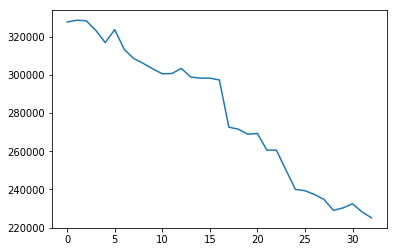

In [201]:
plt.plot(data[1,0,0,0,0])

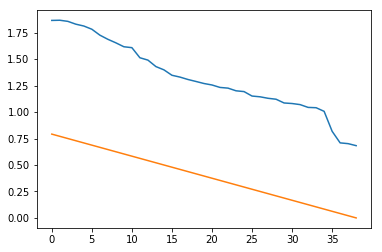

In [228]:
plt.plot(np.mean(data[:,1,1,1,0],axis=0)/(500*1000))
plt.plot(np.arange(len(np.mean(data[:,1,1,1,0],axis=0)))[::-1]/(2*(5**2-1)))

In [150]:
data[0,0,0,0]

array([254593, 256908, 259315, 260013, 258703, 258266, 248614, 234790,
       234103, 233220, 232981, 231929, 229642, 229529, 225482, 219859,
       219063, 218708, 213503, 209350, 185452, 181363, 177553, 162926,
       161639, 157355, 155997, 155830, 151426, 145486, 140696,      0,
            0])

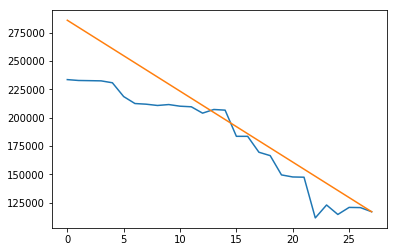

In [168]:
hi=data[0,1,0,0]
plt.plot(hi[:-5])

plt.plot(100000*(np.arange(len(hi[:-5]))[::-1]/(2*(3)**2 -2))+hi[-6])

In [44]:
data[0,0,0]

array([[  4,   2,  93,   1,   0,   0,   0,   0,   0,   0,   0],
       [  1,   2,  90,   7,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,  92,   6,   1,   0,   0,   0,   0,   0,   0],
       [  5,   0,  87,   8,   0,   0,   0,   0,   0,   0,   0],
       [  6,   0,  80,  14,   0,   0,   0,   0,   0,   0,   0],
       [  8,   0,  74,  18,   0,   0,   0,   0,   0,   0,   0],
       [  7,   0,  74,  19,   0,   0,   0,   0,   0,   0,   0],
       [  8,   0,  70,  22,   0,   0,   0,   0,   0,   0,   0],
       [ 11,   0,  77,  12,   0,   0,   0,   0,   0,   0,   0],
       [ 24,   0,  53,  23,   0,   0,   0,   0,   0,   0,   0],
       [ 30,   0,  52,  18,   0,   0,   0,   0,   0,   0,   0],
       [ 40,   0,  44,  16,   0,   0,   0,   0,   0,   0,   0],
       [ 58,   0,  29,  13,   0,   0,   0,   0,   0,   0,   0],
       [ 69,   0,  18,  13,   0,   0,   0,   0,   0,   0,   0],
       [ 71,   0,  22,   7,   0,   0,   0,   0,   0,   0,   0],
       [ 83,   0,  13,   4,   0,   0,   

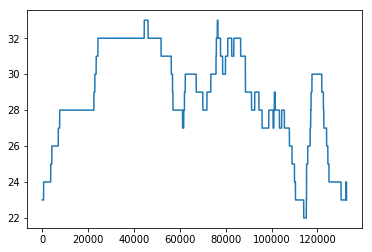

In [85]:
plt.plot(lens)

array([     0.,      0.,      0.,      0., 121433., 122753., 123115.,
       123890., 119972., 129190., 132678., 132678., 132678., 132678.,
       132678., 132678., 132678., 132678., 132678., 132678., 132678.,
       132678., 132678., 132678., 132678., 132678., 132678., 132678.,
       132678., 132678., 132678., 132678., 132678.])

In [78]:
pad_data[100]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 100, 100, 100, 100])

In [54]:
 data[0,0,0,0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True])

In [55]:
[False]*4

[False, False, False, False]

In [79]:
s=.1
r=.5
m=.1
K=1000
se = .5*s*m*np.log(2/m) / r
p = (np.exp(-2*se)-1)/ (np.exp(-4*se*K)-1)

In [80]:
p

0.058155079116972264